In [2]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import importnb
with importnb.Notebook():
    from matrix_based_entropy_estimators import IT_calculator

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [4]:
class SimpleCNN(nn.Module):
    "Build a simple 3 layer CNN model"
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 32, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# transform the scale data into [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load the train/test dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=60, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=60, shuffle=False)
# data_example, label = next(iter(trainloader))
# print(data_example)

model = SimpleCNN().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(torch.load('SimpleCNN.pth'))
model.eval()

# Evaluation on test set
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 98.90%


In [20]:
# model.eval()

4


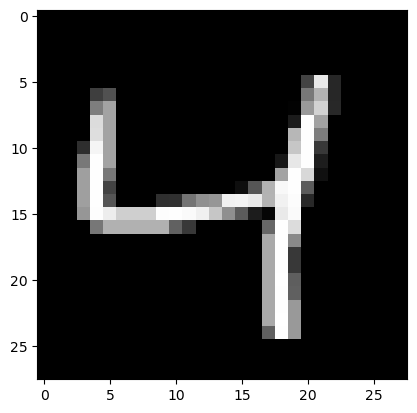

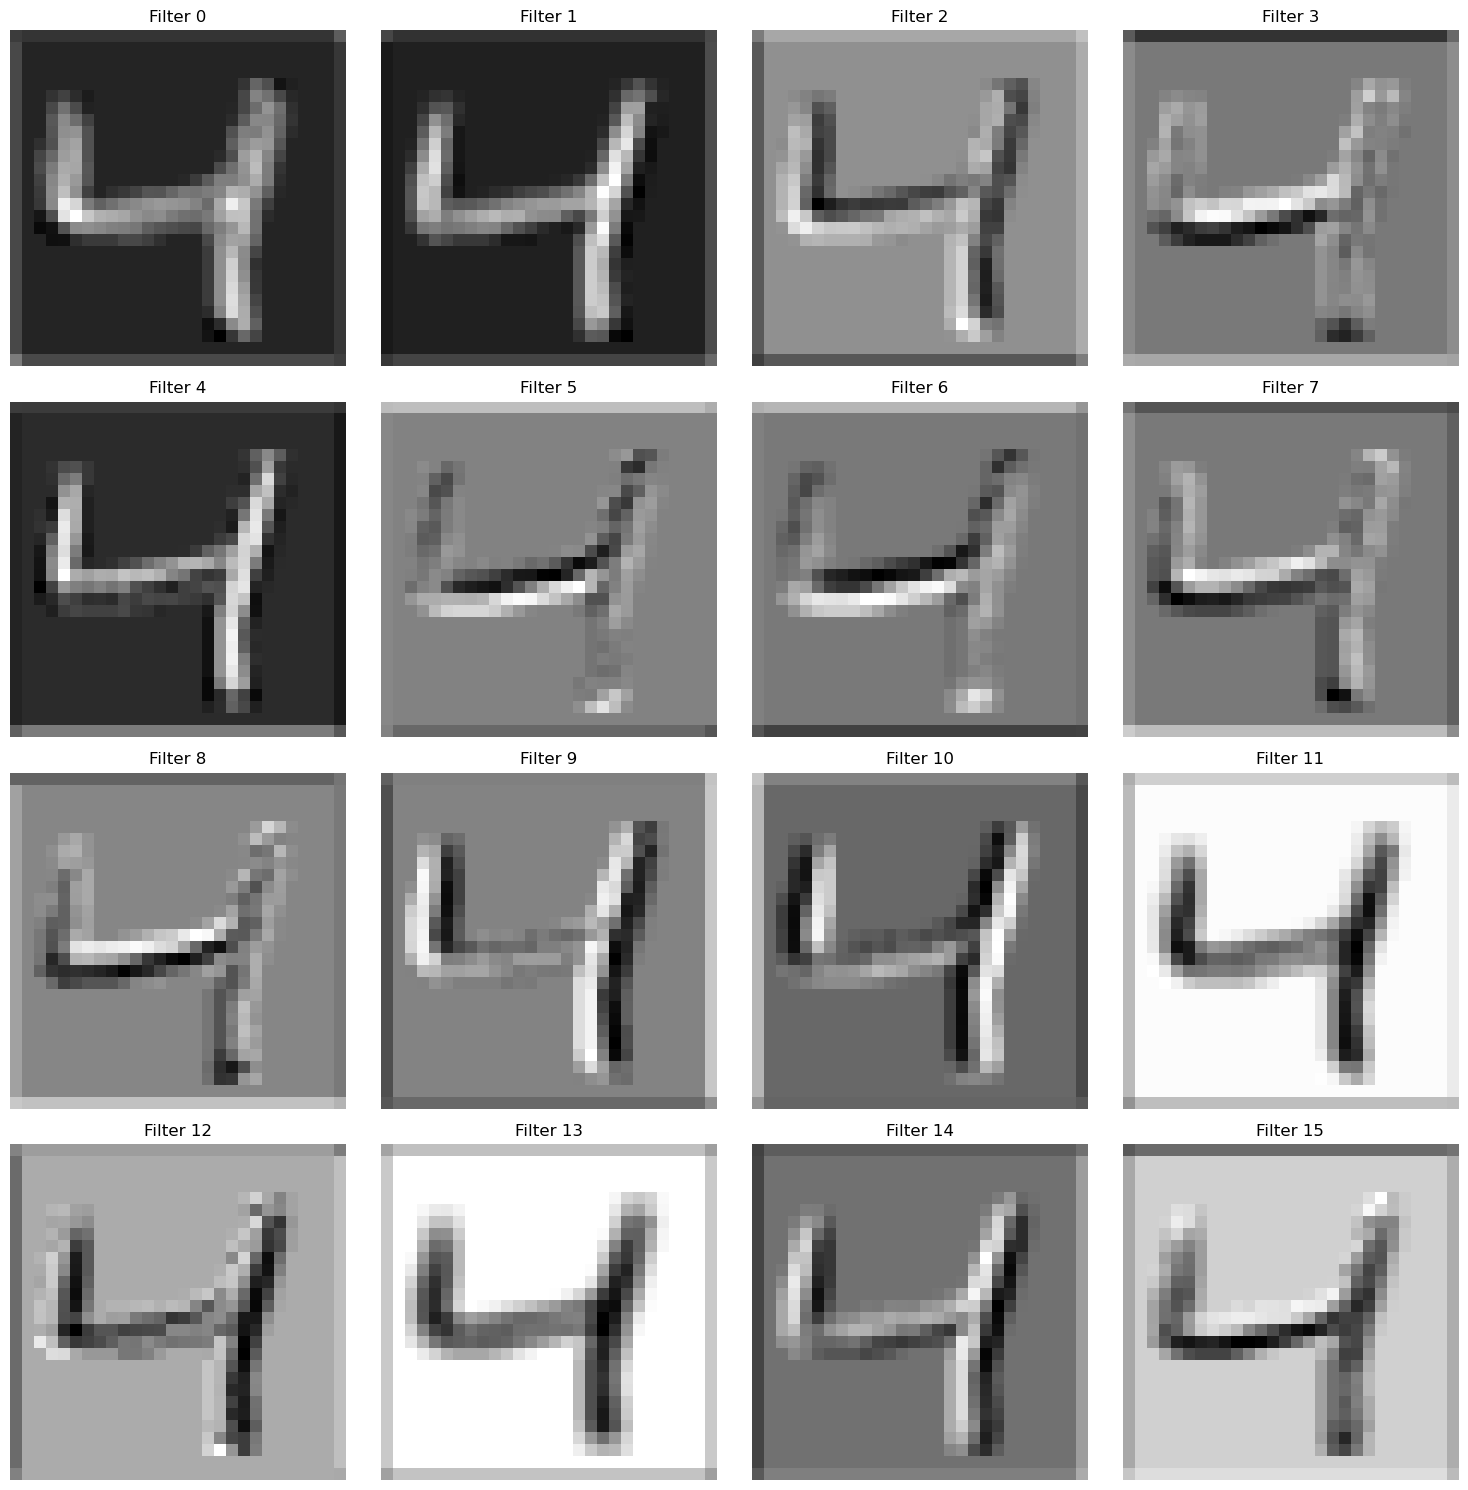

In [7]:
image, _ = trainset[2]  # Get a sample image from the dataset
label = _
image = image.unsqueeze(0)  # Add a batch dimension

# get an intermediate_output of the model
intermediate_output = model.conv1(image)  # Output of the first convolutional layer
# intermediate_output = model.relu1(intermediate_output)  # Apply ReLU activation
# intermediate_output = model.pool1(intermediate_output)  # Apply max pooling
# intermediate_output = model.conv2(intermediate_output) 
# intermediate_output = model.relu2(intermediate_output)  # Apply ReLU activation
# intermediate_output = model.pool2(intermediate_output)  # Apply max pooling

num_filters = intermediate_output.shape[1]
fig = plt.figure()
plt.imshow(image[0,0].detach().numpy(),cmap='gray')
print(label)

# visualize different feature map
num_rows = (num_filters + 3) // 4  # Calculate the number of rows needed
fig, axs = plt.subplots(num_rows, 4, figsize=(15, 15))

# fig, axs = plt.subplots(int(num_filters/2), 2, figsize=(15, 15))
for i in range(num_filters):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index

    axs[row, col].imshow(intermediate_output[0, i].detach().numpy(), cmap='gray')
    axs[row, col].set_title(f'Filter {i}')
    axs[row, col].axis('off')

# Hide empty subplots
if num_filters % 4 != 0:
    for j in range(num_filters % 4, 4):
        axs[num_rows - 1, j].axis('off')

plt.tight_layout()
plt.show()

In [29]:
# get a subsample in the trainset and evaluate IT quantity.
N_sample = 100
indices = random.sample(range(len(trainset)), N_sample)
# Create a new DataLoader with the selected indices
sample_trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices))

# X_hat is the intermediate representation, Y is the label.
IT = IT_calculator()
inputs = torch.empty(0)
X_hat = torch.empty(0)
Y = torch.empty(0)
filters_entropy = []
with torch.no_grad():
    for images, labels in sample_trainloader:
            intermediate_output = model.conv1(images) 
            # intermediate_output = model.relu1(intermediate_output)  # Apply ReLU activation
            # intermediate_output = model.pool1(intermediate_output)  # Apply max pooling
            # intermediate_output = model.conv2(intermediate_output) 
            # intermediate_output = model.relu2(intermediate_output)  # Apply ReLU activation
            # intermediate_output = model.pool2(intermediate_output)  # Apply max pooling
            inputs = torch.cat((inputs, images), dim=0)
            X_hat = torch.cat((X_hat, intermediate_output), dim=0)
            Y = torch.cat((Y, labels), dim=0)

X_hat = torch.transpose(X_hat,0,1)
inputs = inputs.squeeze()

# try standardization on Y
Y = (Y-Y.mean())/Y.std()



In [32]:
# record IT quantity related to different filters.
filters_entropy = []
filters_MI = []
filters_MI_Y = []

for i in range(X_hat.shape[0]):
    _ = IT.Entropy(X_hat[i])
    filters_entropy.append(_)
    filters_MI.append(IT.MI(X_hat[i],inputs))
    filters_MI_Y.append(IT.MI(X_hat[i],Y))

In [33]:
beta = 1.53
filters_useful_min = torch.sub(torch.tensor(filters_MI), torch.tensor(filters_MI_Y) * torch.tensor(beta))
beta = 0.1
filters_useful_max = torch.sub(torch.tensor(filters_MI_Y), torch.tensor(beta) * torch.tensor(filters_MI))


filters_MI_Y = np.array(filters_MI_Y)
filters_useful_min = np.array(filters_useful_min)
filters_useful_max = np.array(filters_useful_max)
filters_entropy = np.array(filters_entropy)
filters_MI = np.array(filters_MI)

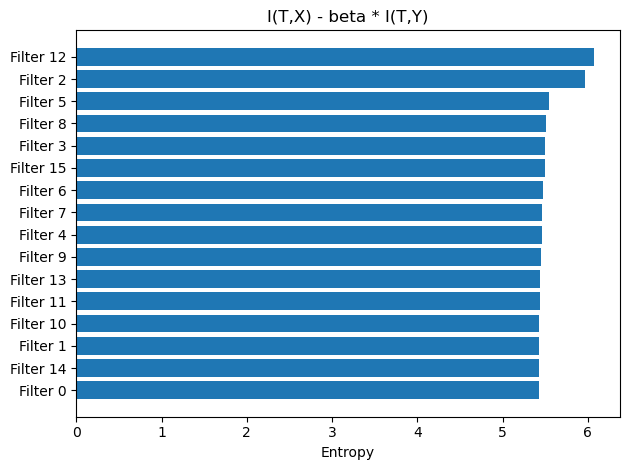

In [34]:
# visualization
data = filters_useful_min

# Get the original indices
indices = np.arange(len(data))

# Sort the data and indices in descending order
sorted_indices = np.argsort(data)
sorted_data = data[sorted_indices]
sorted_indices = indices[sorted_indices]

# Generate labels using the original indices
labels = [f"Filter {i}" for i in sorted_indices]
plt.Figure(figsize=(20,30))
# Plot the horizontal bar chart
plt.barh(labels, sorted_data)

# Set the x-axis label
plt.xlabel('Entropy')

# Set the title of the plot
plt.title('I(T,X) - beta * I(T,Y)')
plt.tight_layout()
# Show the plot
plt.show()

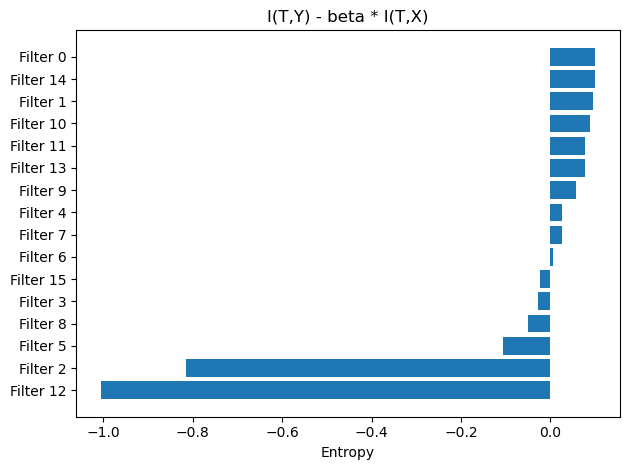

In [36]:
data = filters_useful_max

# Get the original indices
indices = np.arange(len(data))

# Sort the data and indices in descending order
sorted_indices = np.argsort(data)
sorted_data = data[sorted_indices]
sorted_indices = indices[sorted_indices]

# Generate labels using the original indices
labels = [f"Filter {i}" for i in sorted_indices]
plt.Figure(figsize=(20,30))
# Plot the horizontal bar chart
plt.barh(labels, sorted_data)

# Set the x-axis label
plt.xlabel('Entropy')

# Set the title of the plot
plt.title('I(T,Y) - beta * I(T,X)')
plt.tight_layout()
# Show the plot
plt.show()

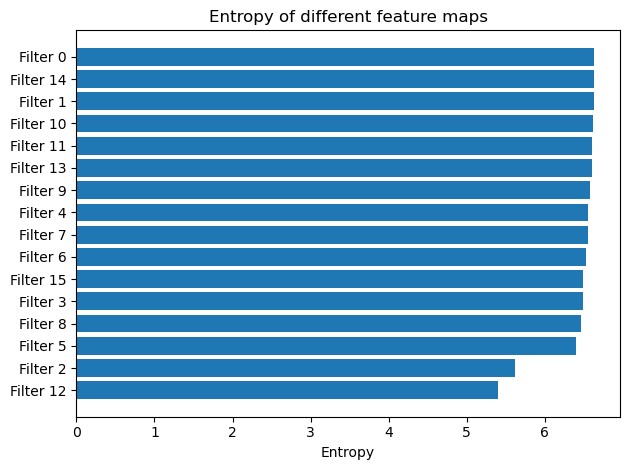

In [37]:
data = filters_entropy

# Get the original indices
indices = np.arange(len(data))

# Sort the data and indices in descending order
sorted_indices = np.argsort(data)
sorted_data = data[sorted_indices]
sorted_indices = indices[sorted_indices]

# Generate labels using the original indices
labels = [f"Filter {i}" for i in sorted_indices]
plt.Figure(figsize=(20,30))
# Plot the horizontal bar chart
plt.barh(labels, sorted_data)

# Set the x-axis label
plt.xlabel('Entropy')

# Set the title of the plot
plt.title('Entropy of different feature maps')
plt.tight_layout()
# Show the plot
plt.show()

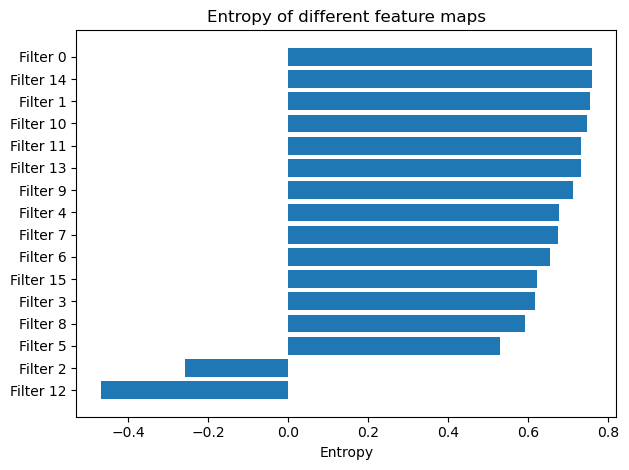

In [38]:
data = filters_MI_Y

# Get the original indices
indices = np.arange(len(data))

# Sort the data and indices in descending order
sorted_indices = np.argsort(data)
sorted_data = data[sorted_indices]
sorted_indices = indices[sorted_indices]

# Generate labels using the original indices
labels = [f"Filter {i}" for i in sorted_indices]
plt.Figure(figsize=(20,30))
# Plot the horizontal bar chart
plt.barh(labels, sorted_data)

# Set the x-axis label
plt.xlabel('Entropy')

# Set the title of the plot
plt.title('Entropy of different feature maps')
plt.tight_layout()
# Show the plot
plt.show()

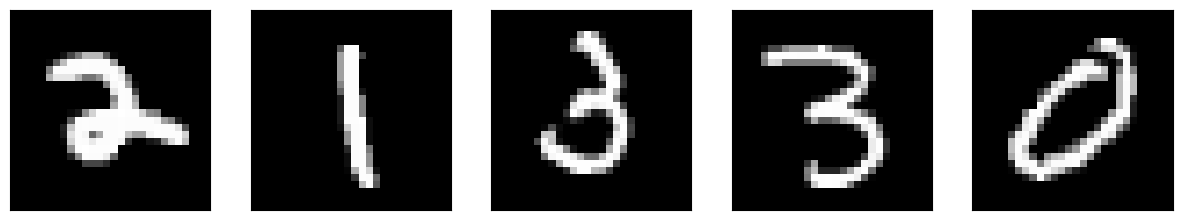

In [14]:
N_sample = 5
indices = random.sample(range(len(trainset)), N_sample)
# Create a new DataLoader with the selected indices
sample_trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices))
IT = IT_calculator()
inputs = torch.empty(0)

fig, axs = plt.subplots(1, N_sample, figsize=(15, 15))
i = 0
with torch.no_grad():
    for images, labels in sample_trainloader:
        intermediate_output = model.conv1(images) 
        axs[i].imshow(images[0, 0].detach().numpy(), cmap='gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        inputs = torch.cat((inputs, images), dim=0)
        i += 1
